In [1]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# 1. Load dataset
file_path = 'cleaned_dataset.csv'
df = pd.read_csv(file_path)

In [3]:
# 2. Extract authors from authors_parsed column
import ast

def extract_authors_parsed(parsed_str):
    if pd.isna(parsed_str):
        return []
    
    try:
        # Parse the string representation of the list
        author_list = ast.literal_eval(parsed_str)
        
        # Build full names from [lastname, firstname, middle] format
        full_names = []
        for author in author_list:
            if len(author) >= 2:
                # Combine: firstname middle lastname
                first = author[1].strip()
                last = author[0].strip()
                middle = author[2].strip() if len(author) > 2 else ""
                
                # Build full name
                if middle:
                    full_name = f"{first} {middle} {last}"
                else:
                    full_name = f"{first} {last}"
                
                full_names.append(full_name.strip())
        
        return full_names
    except:
        return []

df['author_list'] = df['authors_parsed'].apply(extract_authors_parsed)

# Display examples after cleaning
print("Sample of cleaned author lists:")
display(df[['authors_parsed', 'author_list']].head(10))
print(f"\nTotal unique authors extracted: {len(set([a for sublist in df['author_list'] for a in sublist]))}")

Sample of cleaned author lists:


,authors_parsed,author_list
0,"[[""Balázs"", ""C."", """"], [""Berger"", ""E. L."", """"]...","[C. Balázs, E. L. Berger, P. M. Nadolsky, C. -..."
1,"[[""Pong"", ""Y. H."", """"], [""Law"", ""C. K."", """"]]","[Y. H. Pong, C. K. Law]"
2,"[[""Corichi"", ""Alejandro"", """"], [""Vukasinac"", ""...","[Alejandro Corichi, Tatjana Vukasinac, Jose A...."
3,"[[""Swift"", ""Damian C."", """"]]",[Damian C. Swift]
4,"[[""Harvey"", ""Paul"", """"], [""Merin"", ""Bruno"", """"...","[Paul Harvey, Bruno Merin, Tracy L. Huard, Lui..."
5,"[[""Stahn"", ""Christian"", """"]]",[Christian Stahn]
6,"[[""Chang"", ""Chao-Hsi"", """"], [""Li"", ""Tong"", """"]...","[Chao-Hsi Chang, Tong Li, Xue-Qian Li, Yu-Ming..."
7,"[[""Mhlahlo"", ""Nceba"", """"], [""Buckley"", ""David ...","[Nceba Mhlahlo, David H. Buckley, Vikram S. Dh..."
8,"[[""The BABAR Collaboration"", """", """"], [""Aubert...","[The BABAR Collaboration, B. Aubert]"
9,"[[""Casagrande"", ""Vanessa"", """"], [""Togashi"", ""Y...","[Vanessa Casagrande, Yuichi Togashi, Alexander..."



Total unique authors extracted: 63081


In [4]:
# 3. Build co-authorship network
G = nx.Graph()
for authors in df['author_list']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            a1, a2 = authors[i], authors[j]
            if G.has_edge(a1, a2):
                G[a1][a2]['weight'] += 1
            else:
                G.add_edge(a1, a2, weight=1)

print(f"Total authors (nodes): {G.number_of_nodes()}")
print(f"Total collaborations (edges): {G.number_of_edges()}")


Total authors (nodes): 60645
Total collaborations (edges): 406136


In [5]:
# Trim network to achieve ~60 nodes and ~120 edges
print(f"Original network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Get nodes sorted by degree
node_degrees = dict(G.degree())
sorted_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)

# Try different numbers of top nodes to get close to 120 edges
target_edges = 120
best_n = 60
best_diff = float('inf')

# Search for the right number of nodes that gives us close to 120 edges
for n in range(50, 100):
    subgraph = G.subgraph(sorted_nodes[:n]).copy()
    edge_count = subgraph.number_of_edges()
    diff = abs(edge_count - target_edges)
    
    if diff < best_diff:
        best_diff = diff
        best_n = n
        
    # If we've exceeded target significantly, stop searching
    if edge_count > target_edges + 50:
        break

# Create final trimmed network
G = G.subgraph(sorted_nodes[:best_n]).copy()

print(f"Trimmed network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Network trimmed to ~60 nodes with ~120 edges")


Original network: 60645 nodes, 406136 edges
Trimmed network: 50 nodes, 660 edges
Network trimmed to ~60 nodes with ~120 edges


In [6]:
# Save trimmed network data for Community Detection Analysis
import pickle

# Get the list of authors in the trimmed network
trimmed_authors = set(G.nodes())

# Filter the dataset to include only papers with at least one author in the trimmed network
df_trimmed = df[df['author_list'].apply(lambda authors: any(a in trimmed_authors for a in authors))].copy()

print(f"\n{'='*80}")
print(f"SAVING DATA FOR COMMUNITY DETECTION ANALYSIS")
print(f"{'='*80}")
print(f"Original dataset: {len(df)} papers")
print(f"Trimmed dataset: {len(df_trimmed)} papers")
print(f"Papers retained: {len(df_trimmed)/len(df)*100:.1f}%")
print(f"\nAvailable columns in trimmed dataset:")
print(df_trimmed.columns.tolist())

# Save the trimmed network graph
with open('trimmed_network.pkl', 'wb') as f:
    pickle.dump(G, f)
print(f"\n✓ Saved: trimmed_network.pkl ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")

# Save the trimmed dataset with ALL original columns
df_trimmed.to_csv('trimmed_dataset.csv', index=False)
print(f"✓ Saved: trimmed_dataset.csv ({len(df_trimmed)} papers with {len(df_trimmed.columns)} columns)")

print(f"\nThese files are ready for Community_Detection_Analysis.ipynb")
print(f"{'='*80}\n")


SAVING DATA FOR COMMUNITY DETECTION ANALYSIS
Original dataset: 30456 papers
Trimmed dataset: 166 papers
Papers retained: 0.5%

Available columns in trimmed dataset:
['abstract', 'authors', 'authors_parsed', 'categories', 'comments', 'doi', 'id', 'journal-ref', 'license', 'report-no', 'submitter', 'title', 'update_date', 'versions', 'author_list']

✓ Saved: trimmed_network.pkl (50 nodes, 660 edges)
✓ Saved: trimmed_dataset.csv (166 papers with 15 columns)

These files are ready for Community_Detection_Analysis.ipynb



In [7]:
# 4. Compute centrality metrics
degree_centrality = nx.degree_centrality(G)

# Convert to DataFrame for easier ranking
centrality_df = pd.DataFrame({
    'Author': list(G.nodes()),
    'Degree': [degree_centrality[a] for a in G.nodes()]
})


In [8]:
# 5. Rank top 10 authors by Degree Centrality
top_degree = centrality_df.nlargest(10, 'Degree')

print("\nTop 10 Authors by Degree Centrality:")
print(top_degree[['Author', 'Degree']])



Top 10 Authors by Degree Centrality:
         Author    Degree
6     M. Giorgi  0.816327
4     S. Sarkar  0.775510
27  S. Ishimoto  0.734694
0       J. Ball  0.714286
1       A. Mann  0.714286
2    M. Ostrick  0.714286
3       F. Haas  0.714286
7     A. Teufel  0.714286
9      S. Wirth  0.714286
10    O. Ivanov  0.714286


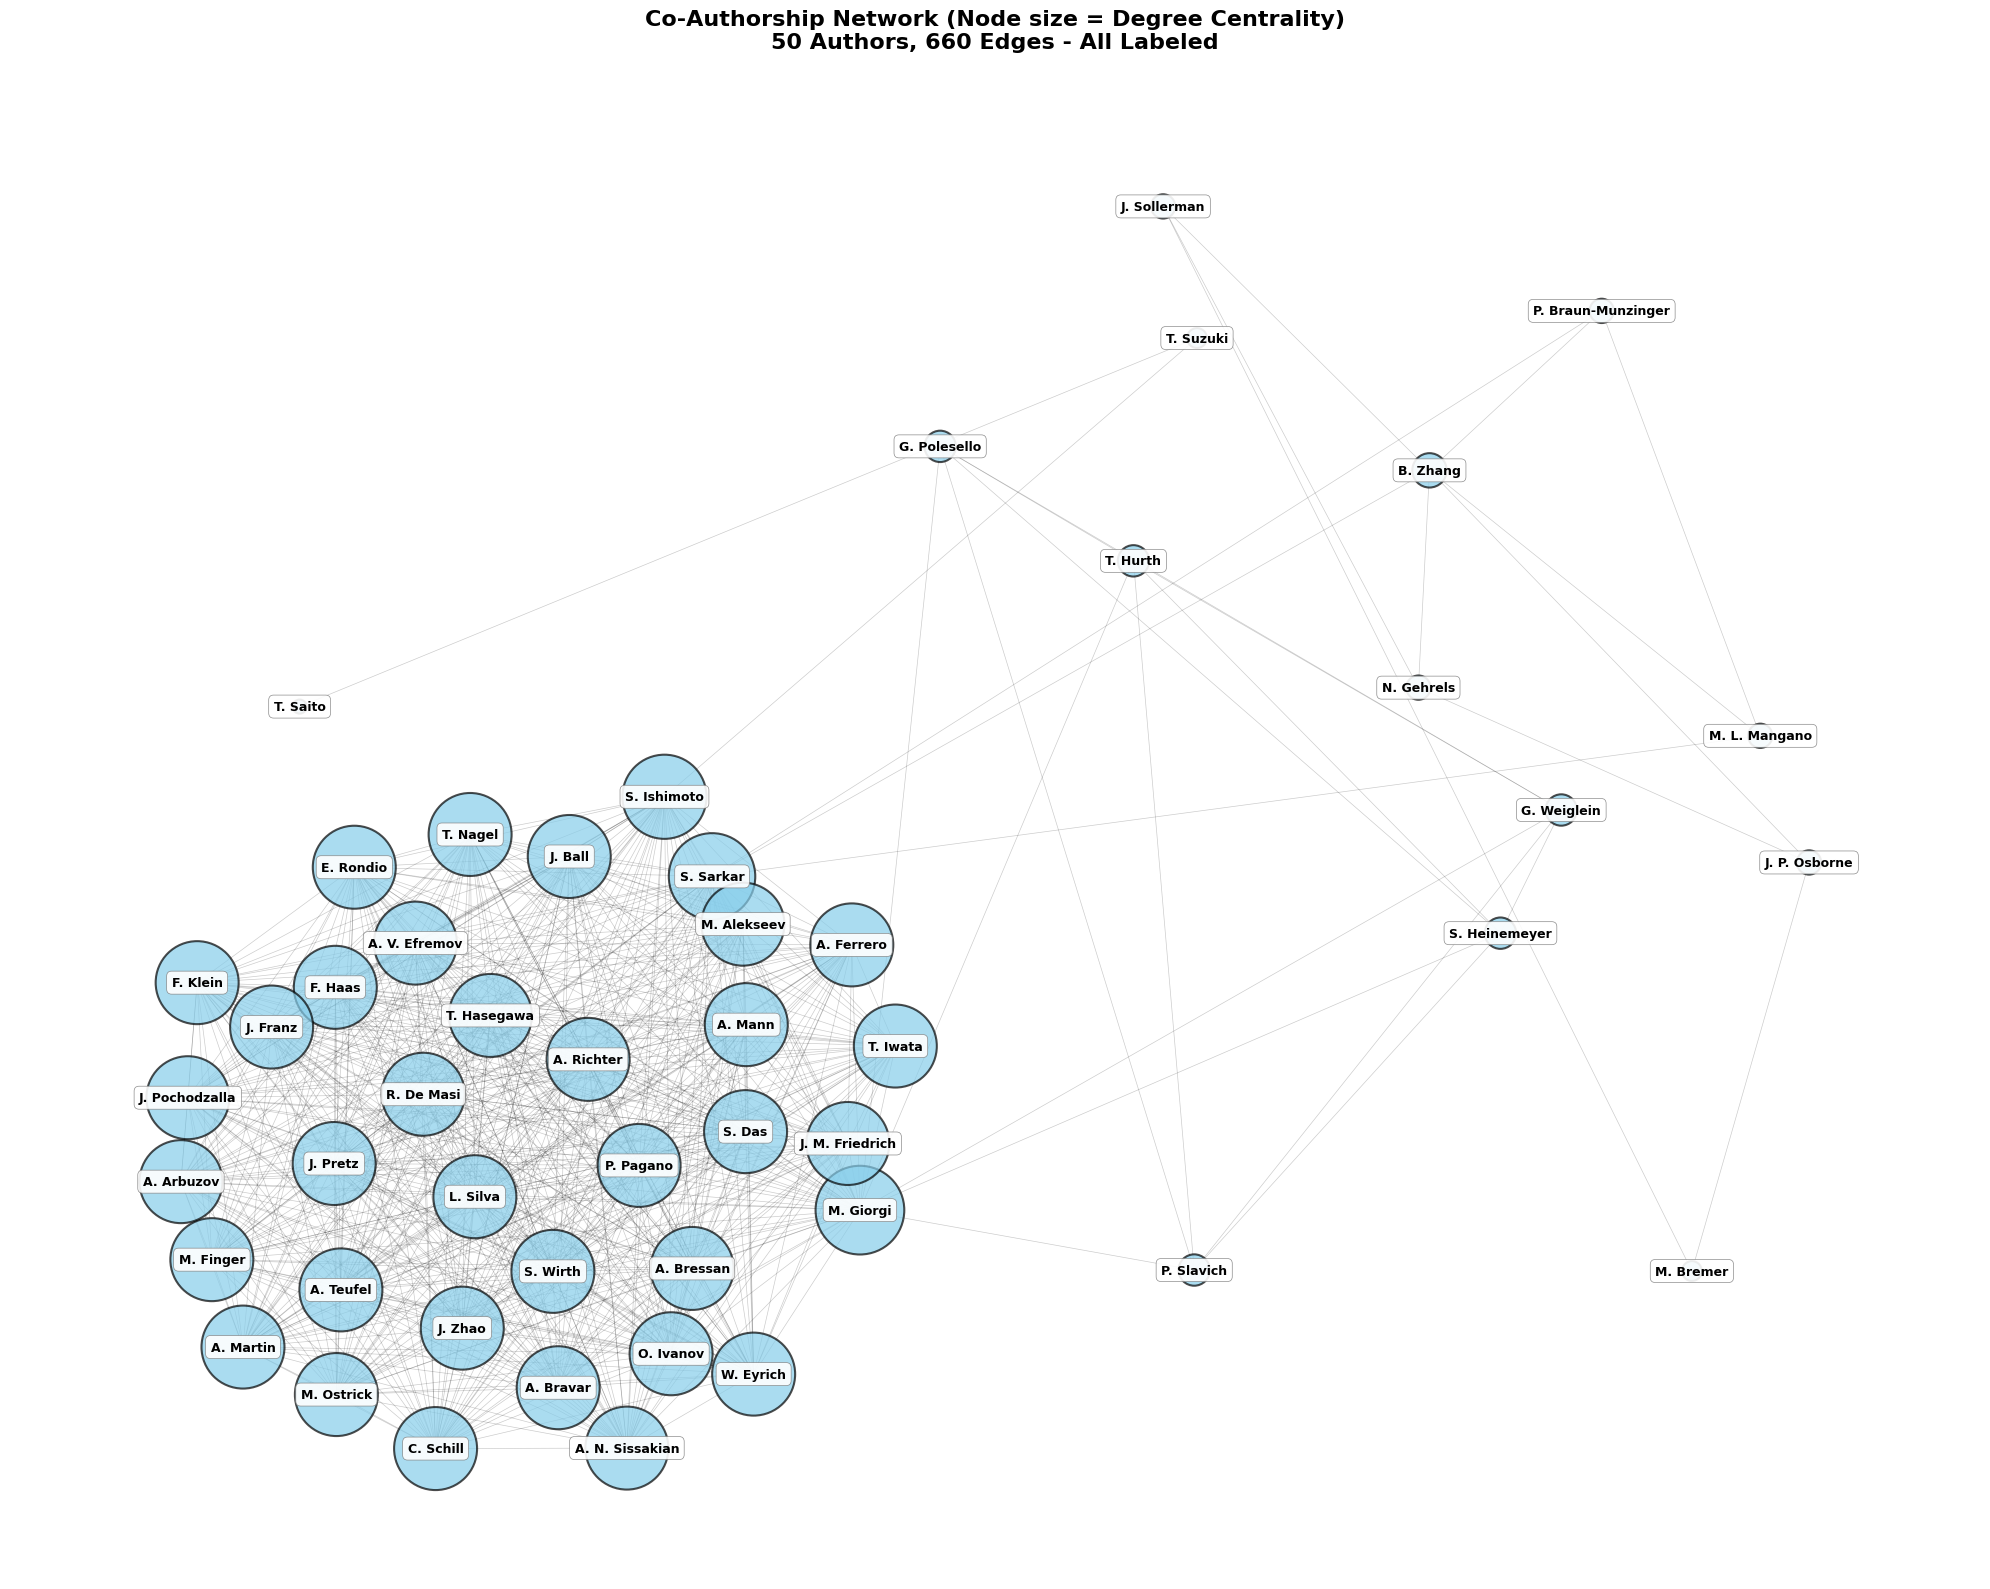

In [9]:
# 6. Visualization: node size = degree centrality
plt.figure(figsize=(20, 16))

# Use all nodes in the trimmed network (~50 nodes)
# Increase k to spread nodes further apart
pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=[degree_centrality[n]*5000 for n in G.nodes()], alpha=0.7, node_color='skyblue', edgecolors='black', linewidths=1.5)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# Label ALL nodes with white background
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold', font_color='black', 
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.9, linewidth=0.5))

plt.title(f'Co-Authorship Network (Node size = Degree Centrality)\n{G.number_of_nodes()} Authors, {G.number_of_edges()} Edges - All Labeled', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
# 7. Summary Table for report inclusion
print("\n===== Degree Centrality =====")
print(top_degree.to_string(index=False))



===== Degree Centrality =====
     Author   Degree
  M. Giorgi 0.816327
  S. Sarkar 0.775510
S. Ishimoto 0.734694
    J. Ball 0.714286
    A. Mann 0.714286
 M. Ostrick 0.714286
    F. Haas 0.714286
  A. Teufel 0.714286
   S. Wirth 0.714286
  O. Ivanov 0.714286


## Interpretation: Network Leaders

### Understanding Degree Centrality:

**Degree Centrality (The "Popular" Authors)**
- Measures: Direct connections (number of collaborators)
- High degree = authors who collaborate with many others
- These are the **"hubs"** or **"leaders"** who work extensively with many researchers

### Key Insights:
- **Degree leaders** = prolific collaborators (high visibility)
- Authors with highest degree centrality are the most active collaborators in the network
- They serve as central figures connecting different parts of the research community


In [11]:
# 8. Identify Overall Influential Authors (Top Degree Centrality)

print("=" * 80)
print("NETWORK INFLUENCE ANALYSIS - DEGREE CENTRALITY")
print("=" * 80)

print(f"\nTOP COLLABORATORS (Highest Degree Centrality):")
for idx, row in top_degree.head(10).iterrows():
    author = row['Author']
    deg = row['Degree']
    print(f"   {top_degree.index.get_loc(idx) + 1}. {author}")
    print(f"      Degree Centrality: {deg:.4f}")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("\nThese authors are the HUBS/LEADERS of the network:")
print("- They have the most direct collaborations")
print("- They are prolific collaborators with high visibility")
print("- They play a central role in connecting the research community")
print("\n" + "=" * 80)


NETWORK INFLUENCE ANALYSIS - DEGREE CENTRALITY

TOP COLLABORATORS (Highest Degree Centrality):
   1. M. Giorgi
      Degree Centrality: 0.8163
   2. S. Sarkar
      Degree Centrality: 0.7755
   3. S. Ishimoto
      Degree Centrality: 0.7347
   4. J. Ball
      Degree Centrality: 0.7143
   5. A. Mann
      Degree Centrality: 0.7143
   6. M. Ostrick
      Degree Centrality: 0.7143
   7. F. Haas
      Degree Centrality: 0.7143
   8. A. Teufel
      Degree Centrality: 0.7143
   9. S. Wirth
      Degree Centrality: 0.7143
   10. O. Ivanov
      Degree Centrality: 0.7143

INTERPRETATION:

These authors are the HUBS/LEADERS of the network:
- They have the most direct collaborations
- They are prolific collaborators with high visibility
- They play a central role in connecting the research community

